In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.ticker as ticker
import pandas as pd
import glob
import re
# Statistics
from scipy.stats import norm
from scipy.special import factorial
from scipy.special import gammaln
import scipy.optimize as spo
# Parallel
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

In [26]:
# Matplotlib customize
plt.rcParams['figure.figsize'] = [6,5]
plt.rcParams['figure.dpi'] = 100

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20

plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 4

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.markerscale'] = 1.5
plt.rcParams['legend.borderpad'] = 0.6
plt.rcParams['legend.framealpha'] = 0.7

In [27]:
Data = []
Mass = np.array([])

for f in glob.glob('Data/*.csv'):
    #print(f)
    
    data = pd.read_csv(f,sep=',')
    Data.append(data)

    # Extraer los últimos tres números del nombre del archivo
    match = re.search(r'(\d{3})\.csv$', f)
    if match:
        Mass = np.append(Mass, float(match.group(1)))

# Emparejar los numeros con los dataframes
paired = list(zip(Mass,Data))

# Ordenar los pares segun las masas
Mass_sorted = sorted(paired, key=lambda x: x[0])

# Separar de nuevo los numeros y los dataFrames
Mass_sorted, Data = zip(*Mass_sorted)

# Numpy array
Mass = np.array(Mass_sorted)

print(Mass)

[100. 106. 112. 118. 124. 130. 136. 142. 148. 154. 160.]


In [28]:
# Reading channels
data = Data[4]
labels = list(data.keys())
n = np.array(data[labels[0]])
b = np.array(data[labels[1]])
s = np.array(data[labels[2]])
N = n.shape[0]

In [29]:
# Para el caso 1 canal
data = pd.read_csv('Data/1Channel.csv',sep=',')
labels = list(data.keys())
n = np.array(data[labels[0]])
b = np.array(data[labels[1]])
s = np.array(data[labels[2]])
N = n.shape[0]

In [54]:
def Gauss(x,mean=1.,sigma=0.2):
    return norm.pdf(x,loc=mean,scale=sigma)

In [55]:
def Poisson(n,l):
    return poisson.pmf(n,mu=l)

In [56]:
def Poisson1(n,l):

    if l > 0.:
        log_likelihood = -l + n*np.log(l) - gammaln(n+1)  # Softening parameter
        return np.exp(log_likelihood)
    else:
        return 0.

In [57]:
def Likelihood(p,sigma,n,b,s):

    mu,e = p
    l = mu*s+e*b
    
    return Poisson1(n,l)*Gauss(e,1.,sigma=sigma)

In [58]:
# Probando la funcion de likelihood
Likelihood(np.array([0.4,1.]),0.1,n[0],b[0],s[0])

0.15445412480195864

In [59]:
def GetJointLikelihood(p,sigma,n,b,s):

    JointLike = 0.
    # All the channels
    for c in range(N):
        JointLike += -2*np.log(Likelihood(p,sigma,n[c],b[c],s[c]))

    return JointLike

In [60]:
mu = np.linspace(0.05,3.,20)
Joint = np.zeros_like(mu)
sigma = 0.1
for i in range(len(mu)):
    p = np.array([mu[i],1.0])
    Joint[i] = GetJointLikelihood(p,sigma,n,b,s)

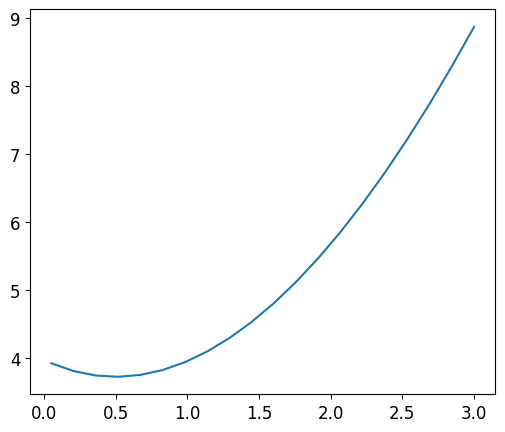

In [61]:
plt.plot(mu,Joint)

In [62]:
def GetJointLikelihoodNuissance(p,mu,sigma,n,b,s):

    e = p[0]
    JointLike = 0.
    # All the channels
    for c in range(N):
        JointLike += -2*np.log(Likelihood(np.array([mu,e]),sigma,n[c],b[c],s[c]))

    return JointLike

In [63]:
def GetDoubleHat(mu,sigma,n,b,s):
    
    bounds =  ((0,10),)
    p0 = np.array([1.])
    result = spo.minimize( GetJointLikelihoodNuissance, p0, args=(mu,sigma,n,b,s), bounds=bounds, options={"disp":False}, method='Nelder-Mead' )
    Doublehat = result.x[0]

    return Doublehat

In [64]:
DoubleHat = np.zeros_like(mu)
for i in range(len(mu)):
    DoubleHat[i] = GetDoubleHat(mu[i],sigma,n,b,s)

In [65]:
def GetDoubleHat2(mu,n,b,s,sigma = 0.1):
    perfil = ( ( b[0] - mu*s[0] - (b[0]*sigma)**2) + np.sqrt( ( b[0] + mu*s[0] - (b[0]*sigma)**2)**2 + 4*(b[0]*sigma)**2*n[0] ))/ (2*b[0])
    return perfil

In [66]:
DoubleHat2 = GetDoubleHat2(mu,n,b,s,sigma=sigma)

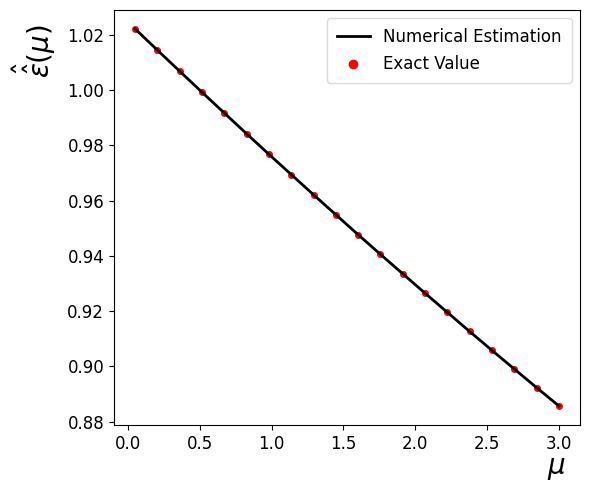

In [67]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(mu,DoubleHat,color='k',lw=2,label='Numerical Estimation')
ax.scatter(mu,DoubleHat2,color='r',marker='o',label='Exact Value')

# Label X
ax.set_xlabel(r'$\mu$')
ax.xaxis.set_label_coords(0.95,-0.07)

# Label Y
ax.set_ylabel(r'$\hat{\hat{\epsilon}}(\mu)$')
ax.yaxis.set_label_coords(-0.12,0.90)

#ax.set_yscale('log')

# Ajustar los márgenes automáticamente
plt.tight_layout()

#Legend
ax.legend(loc='upper right',bbox_to_anchor=(1,1),ncol=1,title='')

#
plt.savefig('DoubleHat.pdf')